In [1]:
try:
    # Check if running in Google Colab
    if 'google.colab' in str(get_ipython()):
        from google.colab import drive
        drive.mount('/content/drive')  # Mount Google Drive
        %cd /content/drive/MyDrive/Colab Notebooks/project_a/src
        !pip install thop
    else:
        print("Not running in Google Colab. Google Drive will not be mounted.")
except NameError:
    print("Not running in an IPython environment.")

Not running in Google Colab. Google Drive will not be mounted.


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torchvision.utils import save_image
from thop import profile
import sys
from PIL import Image


figures_dir = '../report/figures/'
output_dir = '../output/'


print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
    properties = torch.cuda.get_device_properties(0)
    compute_capability = f"{properties.major}.{properties.minor}"
    total_memory = properties.total_memory / 1024**3

    print(f"CUDA Device: {device_name}")
    print(f"CUDA Compute Capability: {compute_capability}")
    print(f"Total Memory: {total_memory:.2f} GB")
else:
    device = torch.device("cpu")
    print("GPU is not available")



PyTorch Version: 2.2.1
CUDA Device: NVIDIA GeForce RTX 4090
CUDA Compute Capability: 8.9
Total Memory: 23.65 GB


In [3]:
from pathlib import Path
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class MHISTDataset(Dataset):
    def __init__(self, images_dir, annotations_file, train=True, transform=None):
        """
        Args:
            images_dir (str): Directory containing all images.
            annotations_file (str): Path to the CSV file with annotations.
            train (bool): Flag indicating whether to load the training or test partition.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images_dir = Path(images_dir)
        self.annotations = pd.read_csv(annotations_file)
        self.transform = transform

        # Filter annotations based on the partition
        partition = 'train' if train else 'test'
        self.annotations = self.annotations[self.annotations['Partition'] == partition]

        # Map folder names to class labels
        self.label_map = {"HP": 0, "SSA": 1}

        # Gather image file paths and their corresponding labels
        self.image_paths = self.annotations['Image Name'].apply(lambda x: self.images_dir / x).tolist()
        self.labels = self.annotations['Majority Vote Label'].map(self.label_map).tolist()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get the image path and corresponding label
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        label = self.labels[idx]
        # Map label to class name, if 0 then HP, if 1 then SSA
        name = "HP" if label == 0 else "SSA"

        if self.transform:
            image = self.transform(image)

        return image, label

## NAS

In [4]:
class fc_Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(fc_Net, self).__init__()
        
        layers = []
        for i in range(len(hidden_size)):
            layers.append(nn.Linear(input_size if i == 0 else hidden_size[i-1], hidden_size[i]))
            layers.append(nn.ReLU())
            
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size[-1], num_classes),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        activations = self.hidden_layers(x)
        x = self.output_layer(activations)
        return x

In [5]:
from utils import get_dataset

(
    channel,
    im_size,
    num_classes,
    class_names,
    mean,
    std,
    train_MNIST_dataset,
    test_MNIST_dataset,
    test_MNIST_dataloader,
    train_MNIST_dataloader,
) = get_dataset("MNIST", "../datasets")


In [6]:
def generate_combinations(options, layers):
    if layers == 0:
        return [[]]
    smaller_combinations = generate_combinations(options, layers - 1)
    return [combination + [option] for combination in smaller_combinations for option in options]


input_size = channel * im_size[0] * im_size[1]  # 1 * 28 * 28
output_size = num_classes  # 10

layer_options = [2, 4]  # Number of hidden layers
neuron_options = [32, 64]  # Number of neurons in each hidden layer

option_combinations = []
for layers in layer_options:
    if layers == 1:
        for neurons in neuron_options:
            option_combinations.append([neurons])
    else:
        option_combinations += generate_combinations(neuron_options, layers)

print(len( option_combinations))
print( "Option Combinations: ", option_combinations)

20
Option Combinations:  [[32, 32], [32, 64], [64, 32], [64, 64], [32, 32, 32, 32], [32, 32, 32, 64], [32, 32, 64, 32], [32, 32, 64, 64], [32, 64, 32, 32], [32, 64, 32, 64], [32, 64, 64, 32], [32, 64, 64, 64], [64, 32, 32, 32], [64, 32, 32, 64], [64, 32, 64, 32], [64, 32, 64, 64], [64, 64, 32, 32], [64, 64, 32, 64], [64, 64, 64, 32], [64, 64, 64, 64]]


In [7]:
import time
from tqdm.auto import tqdm

lr = 0.01
num_epochs = 20
batch_size = 64

(
    channel,
    im_size,
    num_classes,
    class_names,
    mean,
    std,
    train_MNIST_dataset,
    test_MNIST_dataset,
    test_MNIST_dataloader,
    train_MNIST_dataloader,
) = get_dataset("MNIST", "../datasets")

steps = num_epochs * len(train_MNIST_dataloader)
print(f"Total Steps: {steps}")

start_time = time.time()
best_architecture = None
best_accuracy = 0.0

for hidden_size in option_combinations:
    model = fc_Net(input_size, hidden_size, output_size).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)
    
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_MNIST_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            sched.step()
            
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_MNIST_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = correct / total
        print(f"Hidden Size: {hidden_size}, Accuracy: {acc:.4f}")  

        if acc > best_accuracy:
            best_accuracy = acc
            best_architecture = hidden_size

# elapsed time 1607.3 seconds


Total Steps: 37500
Hidden Size: [32, 32], Accuracy: 0.9979
Hidden Size: [32, 64], Accuracy: 0.9988
Hidden Size: [64, 32], Accuracy: 0.9997
Hidden Size: [64, 64], Accuracy: 0.9998
Hidden Size: [32, 32, 32, 32], Accuracy: 0.9972
Hidden Size: [32, 32, 32, 64], Accuracy: 0.9963
Hidden Size: [32, 32, 64, 32], Accuracy: 0.9976
Hidden Size: [32, 32, 64, 64], Accuracy: 0.9972
Hidden Size: [32, 64, 32, 32], Accuracy: 0.9982
Hidden Size: [32, 64, 32, 64], Accuracy: 0.9985
Hidden Size: [32, 64, 64, 32], Accuracy: 0.9983
Hidden Size: [32, 64, 64, 64], Accuracy: 0.9979
Hidden Size: [64, 32, 32, 32], Accuracy: 0.9997
Hidden Size: [64, 32, 32, 64], Accuracy: 0.9996
Hidden Size: [64, 32, 64, 32], Accuracy: 0.9995
Hidden Size: [64, 32, 64, 64], Accuracy: 0.9996
Hidden Size: [64, 64, 32, 32], Accuracy: 0.9996
Hidden Size: [64, 64, 32, 64], Accuracy: 0.9997
Hidden Size: [64, 64, 64, 32], Accuracy: 0.9996
Hidden Size: [64, 64, 64, 64], Accuracy: 0.9997


In [8]:
print( f"Best Architecture: {best_architecture}, Best Accuracy: {best_accuracy:.4f}")

Best Architecture: [64, 64], Best Accuracy: 0.9998


In [9]:
from utils import TensorDataset
def get_syn_dataset (sym_name):
    syn_dataset_file = output_dir + sym_name
    results = torch.load(syn_dataset_file, weights_only=True)
    syn_imgs = results[0][0]
    syn_labels = results[0][1]

    syn_dataset = TensorDataset(syn_imgs, syn_labels)
    channel = syn_imgs.shape[1]
    num_classes = syn_labels.max().item() + 1
    im_size = (syn_imgs.shape[2], syn_imgs.shape[3])

    dataloader = torch.utils.data.DataLoader(syn_dataset, batch_size=32, shuffle=True)
    return syn_dataset, channel, num_classes, im_size, dataloader

In [12]:
import time

lr = 0.01
num_epochs = 20
batch_size = 64

syn_dataset, channel, num_classes, im_size, dataloader = get_syn_dataset('MNIST_real_res.pt')

steps = num_epochs * len(dataloader)
print(f"Total Steps: {steps}")

start_time = time.time()
best_architecture = None
best_accuracy = 0.0

for hidden_size in option_combinations:
    model = fc_Net(input_size, hidden_size, output_size).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)

    for epoch in range(num_epochs):
        model.train()
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            sched.step()
            
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = correct / total
        print(f"Hidden Size: {hidden_size}, Accuracy: {acc:.4f}")  

        if acc > best_accuracy:
            best_accuracy = acc
            best_architecture = hidden_size

# elapsed time 2.8 seonds


Total Steps: 80
Hidden Size: [32, 32], Accuracy: 0.9200
Hidden Size: [32, 64], Accuracy: 0.9500
Hidden Size: [64, 32], Accuracy: 0.9400
Hidden Size: [64, 64], Accuracy: 0.9600
Hidden Size: [32, 32, 32, 32], Accuracy: 0.1000
Hidden Size: [32, 32, 32, 64], Accuracy: 0.1000
Hidden Size: [32, 32, 64, 32], Accuracy: 0.3500
Hidden Size: [32, 32, 64, 64], Accuracy: 0.2400
Hidden Size: [32, 64, 32, 32], Accuracy: 0.2000
Hidden Size: [32, 64, 32, 64], Accuracy: 0.1100
Hidden Size: [32, 64, 64, 32], Accuracy: 0.2700
Hidden Size: [32, 64, 64, 64], Accuracy: 0.3700
Hidden Size: [64, 32, 32, 32], Accuracy: 0.1900
Hidden Size: [64, 32, 32, 64], Accuracy: 0.2600
Hidden Size: [64, 32, 64, 32], Accuracy: 0.2200
Hidden Size: [64, 32, 64, 64], Accuracy: 0.2000
Hidden Size: [64, 64, 32, 32], Accuracy: 0.1100
Hidden Size: [64, 64, 32, 64], Accuracy: 0.1800
Hidden Size: [64, 64, 64, 32], Accuracy: 0.1600
Hidden Size: [64, 64, 64, 64], Accuracy: 0.1000


In [13]:
print( f"Best Architecture: {best_architecture}, Best Accuracy: {best_accuracy:.4f}")

Best Architecture: [64, 64], Best Accuracy: 0.9600


In [14]:
## train model with best architecture using the full dataset

# Load the full dataset
lr = 0.01
num_epochs = 20
batch_size = 64

(
    channel,
    im_size,
    num_classes,
    class_names,
    mean,
    std,
    train_MNIST_dataset,
    test_MNIST_dataset,
    test_MNIST_dataloader,
    train_MNIST_dataloader,
) = get_dataset("MNIST", "../datasets")

model = fc_Net(input_size, best_architecture, output_size).to(device)
print(model)


fc_Net(
  (hidden_layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (output_layer): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


In [17]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)
start_time = time.time()
orig_results = []
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_MNIST_dataloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sched.step()
        
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_MNIST_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = correct / total
        orig_results.append(acc)
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {acc:.4f}")

print("elapsed time: ", time.time() - start_time)

Epoch [1/20], Accuracy: 0.9748
Epoch [2/20], Accuracy: 0.9726
Epoch [3/20], Accuracy: 0.9738
Epoch [4/20], Accuracy: 0.9745
Epoch [5/20], Accuracy: 0.9726
Epoch [6/20], Accuracy: 0.9774
Epoch [7/20], Accuracy: 0.9723
Epoch [8/20], Accuracy: 0.9753
Epoch [9/20], Accuracy: 0.9753
Epoch [10/20], Accuracy: 0.9762
Epoch [11/20], Accuracy: 0.9752
Epoch [12/20], Accuracy: 0.9744
Epoch [13/20], Accuracy: 0.9734
Epoch [14/20], Accuracy: 0.9753
Epoch [15/20], Accuracy: 0.9758
Epoch [16/20], Accuracy: 0.9744
Epoch [17/20], Accuracy: 0.9733
Epoch [18/20], Accuracy: 0.9768
Epoch [19/20], Accuracy: 0.9772
Epoch [20/20], Accuracy: 0.9757
elapsed time:  78.51036381721497


In [18]:
lr = 0.01
num_epochs = 20
batch_size = 64

syn_dataset, channel, num_classes, im_size, dataloader = get_syn_dataset('MNIST_real_res.pt')


criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)
start_time = time.time()
syn_results = []
for epoch in range(num_epochs):
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sched.step()
        
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_MNIST_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = correct / total
        syn_results.append(acc)
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {acc:.4f}")

print("elapsed time: ", time.time() - start_time)

Epoch [1/20], Accuracy: 0.9761
Epoch [2/20], Accuracy: 0.9763
Epoch [3/20], Accuracy: 0.9769
Epoch [4/20], Accuracy: 0.9774
Epoch [5/20], Accuracy: 0.9771
Epoch [6/20], Accuracy: 0.9775
Epoch [7/20], Accuracy: 0.9775
Epoch [8/20], Accuracy: 0.9777
Epoch [9/20], Accuracy: 0.9778
Epoch [10/20], Accuracy: 0.9778
Epoch [11/20], Accuracy: 0.9778
Epoch [12/20], Accuracy: 0.9777
Epoch [13/20], Accuracy: 0.9777
Epoch [14/20], Accuracy: 0.9777
Epoch [15/20], Accuracy: 0.9777
Epoch [16/20], Accuracy: 0.9777
Epoch [17/20], Accuracy: 0.9777
Epoch [18/20], Accuracy: 0.9777
Epoch [19/20], Accuracy: 0.9777
Epoch [20/20], Accuracy: 0.9777
elapsed time:  11.104322910308838


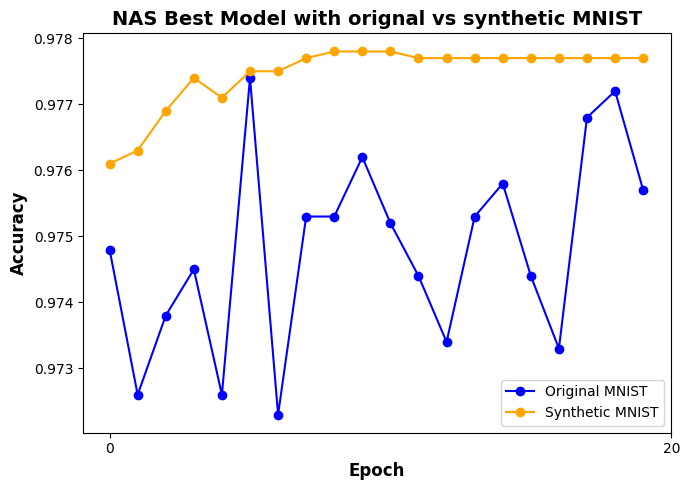

In [20]:
plt.figure(figsize=(7, 5))  # Set figure size

# plot AlexNet accuracy results
plt.plot(orig_results, label='Original MNIST', color='blue', marker='o')
plt.plot(syn_results, label='Synthetic MNIST', color='orange', marker='o')

plt.grid(False)
plt.xticks(np.arange(0, num_epochs+1, 20))
plt.xlabel("Epoch", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold')
plt.title("NAS Best Model with orignal vs synthetic MNIST", fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig(figures_dir + "nas_comparision.png")
